In [0]:
%matplotlib inline
%tensorflow_version 1.x

import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [0]:
train_images = np.reshape(train_images, (60000, 784))
train_images = train_images.astype('float32')/255
test_images = np.reshape(test_images, (10000, 784))
test_images = test_images.astype('float32')/255
ti = list(train_images)

In [0]:
def merge(row, col, connect, num, low):
  if row < 27 and row + 1 < low and connect[row+1][col] > num:
    connect[row+1][col] = num
    merge(row+1, col, connect, num, low)
  if col < 27 and row < low and connect[row][col+1] > num:
    connect[row][col+1] = num
    merge(row, col+1, connect, num, low)
  if row > 0 and connect[row-1][col] > num:
    connect[row-1][col] = num
    merge(row-1, col, connect, num, low)
  if col > 0 and connect[row][col-1] > num:
    connect[row][col-1] = num
    merge(row, col-1, connect, num, low)

In [0]:
# for i in range(100):
#   fig=plt.figure(figsize=(10,3))
#   ax=fig.add_subplot(1,1,1)
#   a=np.copy(train_images[i])
#   ax.imshow(a.reshape((28,28)), cmap='gray', interpolation='nearest', clim=(0,255))
#   plt.show()

In [0]:
def feat(ti, rang1, rang2, rang3):
  features = np.zeros((rang1, 6))
  for i in range(rang1):
    left = rang3
    right = 0
    top = rang3
    bottom = 0
    num = 0
    connect = np.zeros((rang3,rang3))
    for j in range(rang2):
      col = j % rang3
      row = int(j/rang3)
      if ti[i][j] > 0.2:
        ti[i][j] = 0
        if left > col:
          left = col
        if right < col:
          right = col
        if top > row:
          top = row
        bottom = row
      else :
        ti[i][j] = 1
        if num < 1:
          num = 1
        if col < 1:
          if row < 1:
            connect[row][col] = num
            continue
          elif connect[row-1][col] > 0:
            connect[row][col] = connect[row-1][col]
          else:
            num += 1
            connect[row][col] = num
        elif row < 1:
          if connect[row][col-1] > 0:
              connect[row][col] = connect[row][col-1]
          else:
            num += 1
            connect[row][col] = num
        else:
          up = connect[row-1][col]
          notright = connect[row][col-1]
          if up == notright and up > 0:
            connect[row][col] = up
          elif up < notright and up > 0:
            connect[row][col] = up
            merge(row, col, connect, up, row)
          elif notright > 0:
            connect[row][col] = notright
            merge(row, col, connect, notright, row)
          elif up > 0:
            connect[row][col] = up
            merge(row, col, connect, up, row)
          else:
            num += 1
            connect[row][col] = num
    features[i][0] = (bottom - top)/(rang3-1)
    features[i][1] = (right - left)/(rang3-1)
    num = 0
    for j in range(rang2):
      if num < connect[int(j/rang3)][j%rang3]:
        num = connect[int(j/rang3)][j%rang3]
    if num == 1:
      features[i][2] = 1
    elif num == 2:
      features[i][3] = 1
    elif num == 3:
      features[i][4] = 1
    else:
      features[i][5] = 1
  return features

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

augtrain_images = np.concatenate((train_images, feat(train_images, 60000, 784, 28)), axis = 1)
augtest_images = np.concatenate((test_images, feat(test_images, 10000, 784, 28)), axis = 1)

In [0]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(10, activation = 'softmax', input_shape = (784,)))

network.compile(optimizer='rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['acc'])

In [0]:
epochs = 10
history = network.fit(train_images,
                      train_labels,
                      epochs = epochs,
                      batch_size=128,
                      validation_data = (test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.7436 - acc: 0.7883 - val_loss: 0.4169 - val_acc: 0.8831
Epoch 2/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.4041 - acc: 0.8812 - val_loss: 0.3597 - val_acc: 0.8962
Epoch 3/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3659 - acc: 0.8907 - val_loss: 0.3257 - val_acc: 0.9051
Epoch 4/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3462 - acc: 0.8975 - val_loss: 0.3280 - val_acc: 0.8988
Epoch 5/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3356 - acc: 0.9006 - val_loss: 0.3167 - val_acc: 0.9051
Epoch 6/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3267 - acc: 0.9039 - val_loss: 0.3164 - val_acc: 0.9060
Epoch 7/20
60000/60000 [==============================] - 1s 19us/step - loss: 0.3215 - acc: 0.9047 - val_loss: 0.3240 - val_acc

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

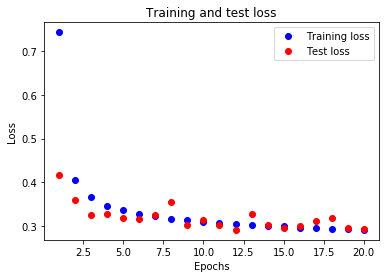

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss withoutwith features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

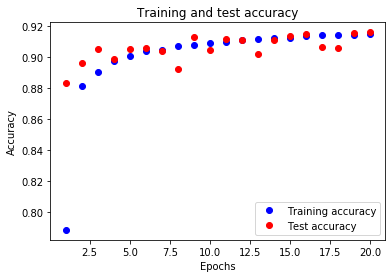

In [0]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy without features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
network2 = models.Sequential()
network2.add(layers.Dense(10, activation = 'softmax', input_shape = (784,)))

network2.compile(optimizer='rmsprop',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [0]:
epochs = 10
history = network2.fit(train_images,
                      train_labels,
                      epochs = epochs,
                      batch_size=128,
                      validation_data = (test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.7314 - acc: 0.7924 - val_loss: 0.4200 - val_acc: 0.8777
Epoch 2/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.4027 - acc: 0.8803 - val_loss: 0.3918 - val_acc: 0.8785
Epoch 3/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.3657 - acc: 0.8896 - val_loss: 0.3268 - val_acc: 0.9030
Epoch 4/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.3461 - acc: 0.8962 - val_loss: 0.3295 - val_acc: 0.9023
Epoch 5/20
60000/60000 [==============================] - 1s 18us/step - loss: 0.3345 - acc: 0.9010 - val_loss: 0.3189 - val_acc: 0.9089
Epoch 6/20
60000/60000 [==============================] - 1s 20us/step - loss: 0.3265 - acc: 0.9034 - val_loss: 0.3210 - val_acc: 0.9048
Epoch 7/20
60000/60000 [==============================] - 1s 21us/step - loss: 0.3213 - acc: 0.9047 - val_loss: 0.3034 - val_acc

In [0]:
history_dict = history.history
loss_values = history_dict['loss']
test_loss_values = history_dict['val_loss']
epochs_range = range(1, epochs + 1)

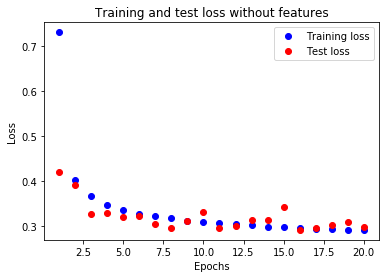

In [0]:
plt.plot(epochs_range, loss_values, 'bo', label='Training loss')
plt.plot(epochs_range, test_loss_values, 'ro', label='Test loss')
plt.title('Training and test loss with features')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
acc_values = history_dict['acc']
test_acc_values = history_dict['val_acc']

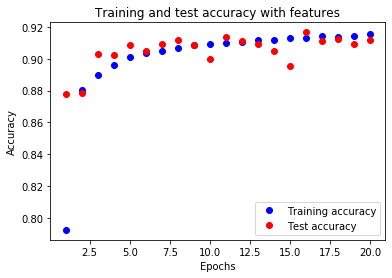

In [0]:
plt.plot(epochs_range, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs_range, test_acc_values, 'ro', label='Test accuracy')
plt.title('Training and test accuracy with features')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()